# Apprentissage orienté agent
### Mini-projet : Comparaison des différents algorithmes d'apprentissage par renforcement.

Nous allons voir dans ce notebook différents algortihmes.
Nous utiliserons la bibliothèque **Open IA Gym** incluant de nombreux jeux afin de pouvoir ensuite développer une IA capable d'apprendre à maximiser son score.

Le jeux que nous utiliserons est "Nchain".

Ce jeu présente des mouvements le long d’une chaîne d’états linéaire, avec deux actions:
en avant, qui se déplace le long de la chaîne mais ne donne aucune récompense en arrière, qui revient au début et a une petite récompense
La fin de la chaîne, cependant, offre une grande récompense, et en allant de l'avant à la fin de la chaîne, cette récompense importante peut être répétée.

À chaque action, il y a une faible probabilité que l'agent "glisse" et que la transition opposée soit prise à la place.

L'état observé est l'état actuel dans la chaîne (0 à n-1).

Le jeu a été conçu et utilisé par Malcolm J. A. Strens : [A Bayesian Framework for Reinforcement Learning](http://ceit.aut.ac.ir/~shiry/lecture/machine-learning/papers/BRL-2000.pdf)

## Importation des différentes bibliothèques

In [1]:
from gym import spaces
import gym
import os
import time
import numpy as np
from collections import deque
import random
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

Nous importons le jeu Nchain que nous stockons dans la variable "ENV" signifiant que c'est notre environnement.
Le nombre d'états et d'actions sont aussi stockées.

In [2]:
ENV = gym.make('NChain-v0')
STATE_SIZE = ENV.observation_space.n
ACTION_SIZE = ENV.action_space.n

In [3]:
print("Nombre d'états:",STATE_SIZE)
print("Nombre d'actions:",ACTION_SIZE)
print("Type des différents états:",ENV.observation_space)
print("Environnement à l'état initial:",ENV.reset())

Nombre d'états: 5
Nombre d'actions: 2
Type des différents états: Discrete(5)
Environnement à l'état initial: 0


## Approche Naive

Dans cette approche, nous fesons une approche consistant à mélanger exploration/exploitation.
La fonction que nous utilisons de la librairie **Numpy** utilise une distribution suivant une loi uniforme contunie, si la valeur de retour est supérieur ou égale à 0.5 alors nous réalisons une action aléatoire.
Sinon nous prenons l'action ayant donné la meilleure récompense pour l'état en question.

In [4]:
def naive_random_reward_agent(env, num_episodes=500):
    r_table = np.zeros((STATE_SIZE,ACTION_SIZE))
    for g in range(num_episodes):
        s = env.reset()
        done= False
        while not done:
            if np.random.random() >= 0.5:
                a = np.random.randint(0, ACTION_SIZE)
            else:
                a = np.argmax(r_table[s, :])
            new_s, r, done, _ = env.step(a)
            r_table[s, a] += r
            s = new_s
    return r_table

In [5]:
print("Exemple d'affichage:")
naive_random_reward_agent(ENV)

Exemple d'affichage:


array([[ 32194., 385050.],
       [ 11056., 134884.],
       [  3948.,  47696.],
       [  1378.,  16248.],
       [ 84184.,  12482.]])

## Q-learning tabulaire

Dans cette section, nous utiliserons l'algorithme du **Q-Learning tabulaire**.
Fonction défini en python avec un nombre d'**épisodes** à prédéfinir initialiser par défaut à 500.

In [6]:
def q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((STATE_SIZE, ACTION_SIZE))
    y = 0.95
    lr = 0.8
    for i in range(num_episodes):
        s = env.reset()
        inc = 0
        done= False
        while not done:
            a = np.argmax(q_table[s, :])
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

In [7]:
print("Exemple d'affichage:")
q_learning_with_table(ENV)

Exemple d'affichage:


array([[26.58605583,  0.        ],
       [28.56274585,  0.        ],
       [29.04445919,  0.        ],
       [35.33099161,  0.        ],
       [84.47539303,  0.        ]])

## Q-learning tabulaire avec epsilon-glouton

Dans l'algorithme précedent, nous exploitions complétement pour chaque état sa valeur de récompense en retour. Mais nous ne savons pas si cela est suffisant pour maximiser notre score, alors nous esseyons d'explorer avec une probabilité epsilon défini et nous verrons les résultats que cela nous donnera.

In [8]:
def eps_greedy_q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((STATE_SIZE, ACTION_SIZE))
    y = 0.95
    eps = 0.5
    lr = 0.8
    decay_factor = 0.999
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        done = False
        while not done:
            if np.random.random() < eps == 0:
                a = np.random.randint(0, ACTION_SIZE)
            else:
                a = np.argmax(q_table[s, :])
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr * (y * np.max(q_table[s, :]) - q_table[s, a])
            s = new_s
    return q_table

In [9]:
print("Exemple d'affichage:")
eps_greedy_q_learning_with_table(ENV)

Exemple d'affichage:


array([[  5.88184609,   0.        ],
       [  4.25323509,   0.        ],
       [ 12.08725325,   0.        ],
       [ 13.01593205,   0.        ],
       [198.12203168,   0.        ]])

## TD-Learning 

Nous utiliserons aussi TD-Learning Tabulaire pour réaliser la comparaison des différents score (seulement la version maximisant le score à chaque étapes d'un épisode.)

In [10]:
def td_learning(env,num_episodes=500):
    v_vector = np.zeros((STATE_SIZE,1))
    y = 0.95
    lr = 0.8
    for i in range(num_episodes):
        s = env.reset()
        inc = 0
        done = False
        while not done:
            a = np.random.randint(0, ACTION_SIZE)
            new_s, r, done, _ = env.step(a)
            v_vector[s,0] += lr*(r+y*v_vector[new_s,0]- v_vector[s,0])
            s = new_s
    return v_vector                

In [11]:
print("Exemple d'affichage:")
td_learning(ENV)

Exemple d'affichage:


array([[16.39062498],
       [17.47396075],
       [17.28670742],
       [16.33505369],
       [21.10380971]])

## Création du Q-Learning neuronal

Une approche alternative consiste à remplacer la recherche de table par un réseau de neurones. Notre réseau de neurones prendrait un état S et une action A en entrée et en sortie la valeur q, c'est-à-dire la récompense possible, pour avoir effectué l'action A à l'état S.

Avec cette implémentation, pour déterminer l’action A à entreprendre à l’état S, notre réseau exécuterait le réseau une fois pour chaque action et sélectionnerait l’action qui produirait la sortie la plus élevée du réseau afin de maximiser la récompense pour l’intelligence artificielle.

Pour former notre réseau, nous utiliserions une approche similaire à celle de l'algorithme Q-Learning d'origine, mais personnalisons-la pour notre réseau de neurones comme suit:

Étape 1: initialiser le réseau neuronal avec des valeurs aléatoires
Étape 2: Pendant que vous jouez, exécutez la boucle suivante
Étape 2.a: Générer un nombre aléatoire compris entre 0 et 1

Si le nombre est supérieur au seuil e, sélectionnez une action aléatoire. Sinon, sélectionnez une action avec la récompense la plus élevée possible en exécutant le réseau de neurones avec l'état actuel et chaque action possible.

In [12]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


Les algorithmes de renforcement en ligne sont malheureusement sujets aux interférences catastrophiques. Une interférence catastrophique se produit lorsqu'un réseau de neurones oublie soudainement ce qu'il a appris précédemment lors de l'apprentissage de nouvelles informations.

Pour contrer les interférences catastrophiques, nous pouvons utiliser une méthode appelée **replay memory**. 
Nous introduisons une mémoire de répétition de taille R dans notre réseau.
A chaque itération, nous formons le réseau avec un lot aléatoire de taille B d’états et d’actions de la mémoire de relecture.
En utilisant cette approche, nous formons en permanence le réseau en utilisant un lot d'échantillons au lieu d'un seul exemple, ce qui permet de lutter contre les interférences catastrophiques.

In [31]:
BATCH_SIZE = 256 # Taille mémoire lors "replay memory"
EPISODES = 1000

In [32]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000000)
        self.gamma = 0.95    
        self.epsilon = 1.0 
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        print(self.model.summary())

    def _build_model(self):
        model = Sequential()
        model.add(Dense(self.state_size, input_dim=1, activation='sigmoid'))
        model.add(Dense(10, activation='sigmoid'))
        model.add(Dense(5, activation='sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=tf.losses.huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0]) 
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)] 
            self.model.train_on_batch(state, target)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [33]:
def q_learning_network(env):
    tab_score = []
    tab_eps = []
    agent = DQNAgent(STATE_SIZE, ACTION_SIZE)    
    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, 1)
        r_tot = 1
        reward_tot=0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, 1)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            r_tot+=1
            reward_tot+=reward
            if done:
                agent.update_target_model()
                if e % 100 == 0:
                    print("episode: {}/{}, score: {}, e: {:.2}"
                          .format(e, EPISODES,reward_tot,agent.epsilon))                
                break
        if len(agent.memory) > BATCH_SIZE:
            agent.replay(BATCH_SIZE)  
        tab_score.append(reward_tot)
        tab_eps.append(agent.epsilon)        
    return tab_score,tab_eps

In [34]:
tab__score_q_network,tab__eps_q_network = q_learning_network(ENV)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 12        
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
None
episode: 0/1000, score: 1218, e: 1.0
episode: 100/1000, score: 1230, e: 0.9
episode: 200/1000, score: 1224, e: 0.82
episode: 300/1000, score: 1244, e: 0.74
episode: 400/1000, score: 1312, e: 0.67
episode: 500/1000, score: 1266, e: 0.61
episode: 600/1000, score: 1356, e: 

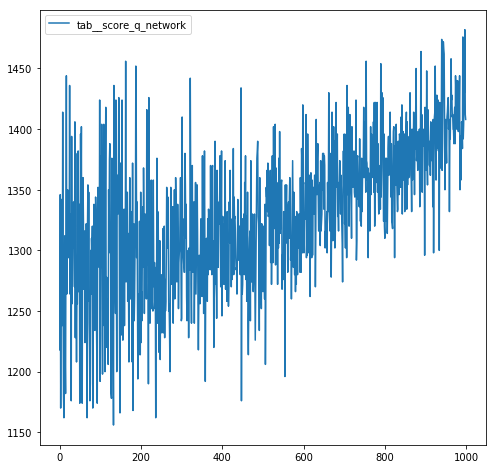

In [35]:
plt.plot(range(0,len(tab__score_q_network)),tab__score_q_network)
plt.legend(['tab__score_q_network'], loc='upper left')
plt.rcParams["figure.figsize"] = [8,8]
fig_size = plt.rcParams["figure.figsize"]
plt.show()

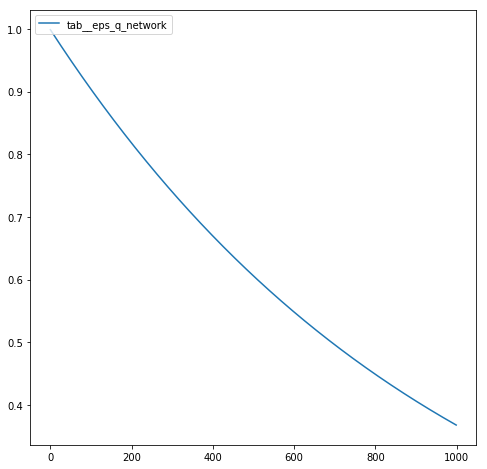

In [36]:
plt.plot(range(0,len(tab__eps_q_network)),tab__eps_q_network)
plt.legend(['tab__eps_q_network'], loc='upper left')
plt.rcParams["figure.figsize"] = [8,8]
fig_size = plt.rcParams["figure.figsize"]
plt.show()

## Comparaison des modèles

On lance les différents  algorithmes avec un nombre d'épisodes  à 1000 avec 100 itérations

In [21]:
def run_game(table, env):
    s = env.reset()
    tot_reward = 0
    done = False
    while not done:
        if table.ndim !=1:
            a = np.argmax(table[s, :])        
        s, r, done, _ = env.step(a)
        tot_reward += r
    return tot_reward

In [22]:
def test_methods(env, num_iterations=100,num_episodes=500):
    arr_tmp_method_un = []
    arr_tmp_method_deux = []
    arr_tmp_method_trois = []
    arr_tmp_method_quatre = []
    winner = np.zeros((4,))
    for g in tqdm_notebook(range(num_iterations)):
        m0_table = naive_random_reward_agent(env, num_episodes)
        m1_table = q_learning_with_table(env, num_episodes)
        m2_table = eps_greedy_q_learning_with_table(env, num_episodes)
        m3_table = td_learning(env, num_episodes)
        m0 = run_game(m0_table, env)
        m1 = run_game(m1_table, env)
        m2 = run_game(m2_table, env)
        m3 = run_game(m3_table,env)
        w = np.argmax(np.array([m0, m1, m2, m3]))
        winner[w] += 1
        if g % 10 == 0:
            print("Game {} of {} and resultats [m0,m1,m2,m3] are {} and scores are {},{},{},{}".format(g + 1, num_iterations,winner,m0, m1,m2,m3))
        arr_tmp_method_un.append(m0)
        arr_tmp_method_deux.append(m1)
        arr_tmp_method_trois.append(m2)
        arr_tmp_method_quatre.append(m3)
    return arr_tmp_method_un,arr_tmp_method_deux,arr_tmp_method_trois,arr_tmp_method_quatre,winner 

In [23]:
arr_result_un,arr_result_deux,arr_result_trois,arr_result_quatre,winner_arr = test_methods(ENV)

Game 1 of 100 and resultats [m0,m1,m2,m3] are [0. 0. 0. 1.] and scores are 1588,3568,3480,3822
Game 11 of 100 and resultats [m0,m1,m2,m3] are [0. 3. 4. 4.] and scores are 1588,3228,3774,3748
Game 21 of 100 and resultats [m0,m1,m2,m3] are [0. 8. 6. 7.] and scores are 1634,3198,3706,3628
Game 31 of 100 and resultats [m0,m1,m2,m3] are [ 0. 11. 12.  8.] and scores are 1622,3808,3510,3490
Game 41 of 100 and resultats [m0,m1,m2,m3] are [ 0. 16. 15. 10.] and scores are 1642,4028,3840,3612
Game 51 of 100 and resultats [m0,m1,m2,m3] are [ 0. 17. 20. 14.] and scores are 1648,3670,3726,3460
Game 61 of 100 and resultats [m0,m1,m2,m3] are [ 0. 23. 24. 14.] and scores are 1608,4680,3806,3518
Game 71 of 100 and resultats [m0,m1,m2,m3] are [ 0. 25. 28. 18.] and scores are 1788,3566,4152,3010
Game 81 of 100 and resultats [m0,m1,m2,m3] are [ 0. 27. 32. 22.] and scores are 1644,3704,3666,3780
Game 91 of 100 and resultats [m0,m1,m2,m3] are [ 0. 32. 36. 23.] and scores are 1670,3704,3576,3592



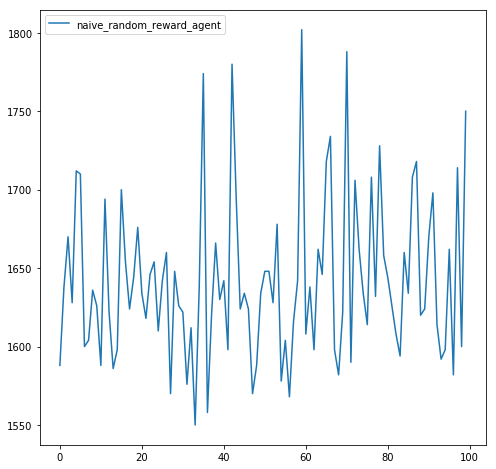

In [24]:
plt.plot(range(0,len(arr_result_un)),arr_result_un)
plt.legend(['naive_random_reward_agent'], loc='upper left')
plt.rcParams["figure.figsize"] = [8,8]
fig_size = plt.rcParams["figure.figsize"]
plt.show()

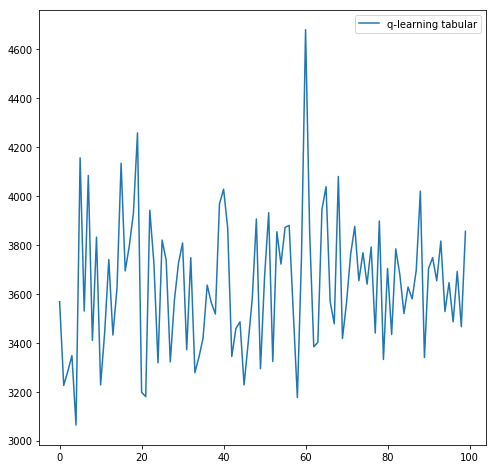

In [25]:
plt.plot(range(0,len(arr_result_deux)),arr_result_deux)
plt.legend(['q-learning tabular'], loc='upper right')
plt.show()

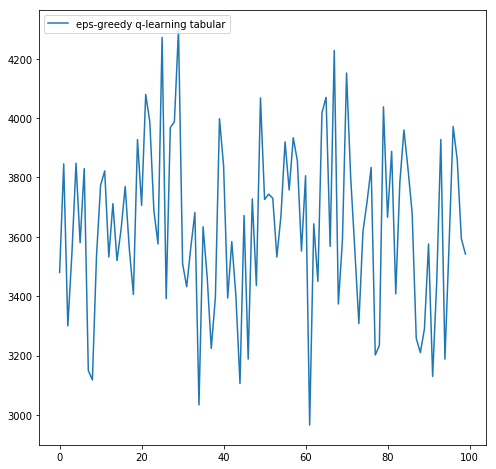

In [26]:
plt.plot(range(0,len(arr_result_trois)),arr_result_trois)
plt.legend(['eps-greedy q-learning tabular'], loc='upper left')
plt.show()

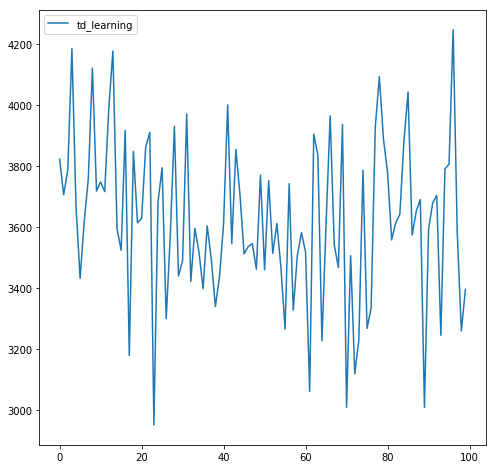

In [27]:
plt.plot(range(0,len(arr_result_quatre)),arr_result_quatre)
plt.legend(['td_learning'], loc='upper left')
plt.show()

### Fréquence des méthodes gagnantes

<BarContainer object of 4 artists>

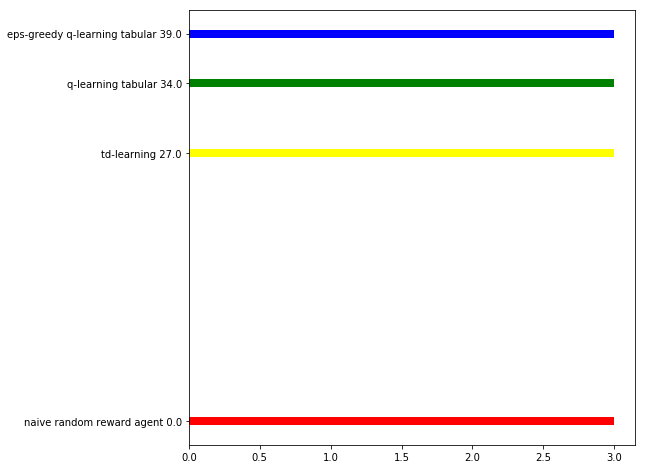

In [28]:
plt.barh(winner_arr,3,color=["red","green","blue","yellow"],tick_label=['naive random reward agent ' + str(winner_arr[0]),'q-learning tabular ' + str(winner_arr[1]),'eps-greedy q-learning tabular ' + str(winner_arr[2]),'td-learning ' + str(winner_arr[3])])

## Statistiques élémentaires

In [37]:
from scipy import stats

La moyenne des récompenses pour chaque algortihmes

In [45]:
print("naive_random_reward_agent",stats.describe(arr_result_un).mean)
print("q_learning_with_table",stats.describe(arr_result_deux).mean)
print("eps_greedy_q_learning_with_table",stats.describe(arr_result_trois).mean)
print("td_learning",stats.describe(arr_result_quatre).mean)
print("Q Learning Network",stats.describe(tab__score_q_network).mean)

naive_random_reward_agent 1641.96
q_learning_with_table 3638.36
eps_greedy_q_learning_with_table 3635.8
td_learning 3622.12
Q Learning Network 1328.362


Voici le minimum et le maximum de chaque algorithmes

In [43]:
print("naive_random_reward_agent",stats.describe(arr_result_un).minmax)
print("q_learning_with_table",stats.describe(arr_result_deux).minmax)
print("eps_greedy_q_learning_with_table",stats.describe(arr_result_trois).minmax)
print("td_learning",stats.describe(arr_result_quatre).minmax)
print("Q Learning Network",stats.describe(tab__score_q_network).minmax)

naive_random_reward_agent (1550, 1802)
q_learning_with_table (3064, 4680)
eps_greedy_q_learning_with_table (2966, 4298)
td_learning (2952, 4246)
Q Learning Network (1156, 1482)


## Conclusion

Nous avons dans ce notebook les principaux algorithmes d'apprentissage par renforcement et réaliser une comparaison. Nous avons aussi utiliser différentes librairies populaires sur Python en rapport avec l'apprentissage.